### Load libraries to read input files.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
%matplotlib inline
import pickle
import ms_analysis as msa

In [2]:
dir(msa)

['Conformer',
 'Kcal2kT',
 'MSout',
 'Microstate',
 'Path',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'bhata_distance',
 'conformers',
 'e2occ',
 'groupms_byconfid',
 'groupms_byenergy',
 'groupms_byiconf',
 'math',
 'ms_charge',
 'ms_convert2occ',
 'ms_convert2sumcrg',
 'ms_counts',
 'ms_energy_stat',
 'np',
 'operator',
 'partial',
 'ph2Kcal',
 'read_conformers',
 'sys',
 'whatchanged_conf',
 'whatchanged_res']

### Read data

In [3]:
in_txt = '/Users/delcck/Desktop/Research/Project_MCCE/work_dir/4lzt/ms_out/pH1eH0ms.txt'

In [4]:
mc = msa.MSout(in_txt)

In [5]:
!ls -d */

4lzt/        __pycache__/


In [6]:
out_pickle = './4lzt/mc.pickle'

with open(out_pickle, 'wb') as fout:
    pickle.dump(mc, fout, protocol=pickle.HIGHEST_PROTOCOL)

Obtain microstate energy, count, and microstate id.
These quantities are saved in a list, sorted using the associated enthalpy from lowest to highest.

In [7]:
ms_orig_list = [
    [ms.E, ms.count, ms.state] for ms in list((mc.microstates.values()))
]

In [8]:
ms_orig_list = sorted(ms_orig_list, key = lambda x: x[0])

In [9]:
print(ms_orig_list[:1])

[[-287.853088, 21, [14, 32, 37, 42, 48, 52, 55, 66, 70, 72, 80, 82, 85, 91, 95, 100, 106, 109, 115, 121, 126, 129, 134, 146, 152, 163, 167, 185, 187, 190, 196, 200, 212, 213, 218, 222, 233, 242, 246, 251, 268]]]


The total number of ms steps (N_ms) and the total number of unique conformers from ms (N_uniq) can be obatined by:

In [10]:
print(mc.N_ms)
print(mc.N_uniq)

1500000
411926


**Optional codes** from Judy

In [11]:
energy_lst_count = np.asarray(
    [
        a for a, f in zip(
            [x[0] for x in ms_orig_list], [x[1] for x in ms_orig_list]
        )
    ]
)
#basically, we are getting the energy & frequency of each ms

In [12]:
#Actually, we only get the energy? why
energy_lst_count.shape

(411926,)

In [13]:
#Actually, we only get the energy? why
energy_lst_count.shape

(411926,)

Judy then fit the distribution by a skewed normal distribution & plot the equation

In [14]:
from scipy.stats import norm, skewnorm

In [15]:
(mu, sigma) = norm.fit(energy_lst_count)

In [16]:
skewness, mean_, std_ = skewnorm.fit(energy_lst_count)

In [17]:
print(mu, sigma)
print(skewness, mean_, std_)

-281.23644219602306 2.4666013857905567
2.3291238180450566 -283.90397314118945 3.6331675647885016


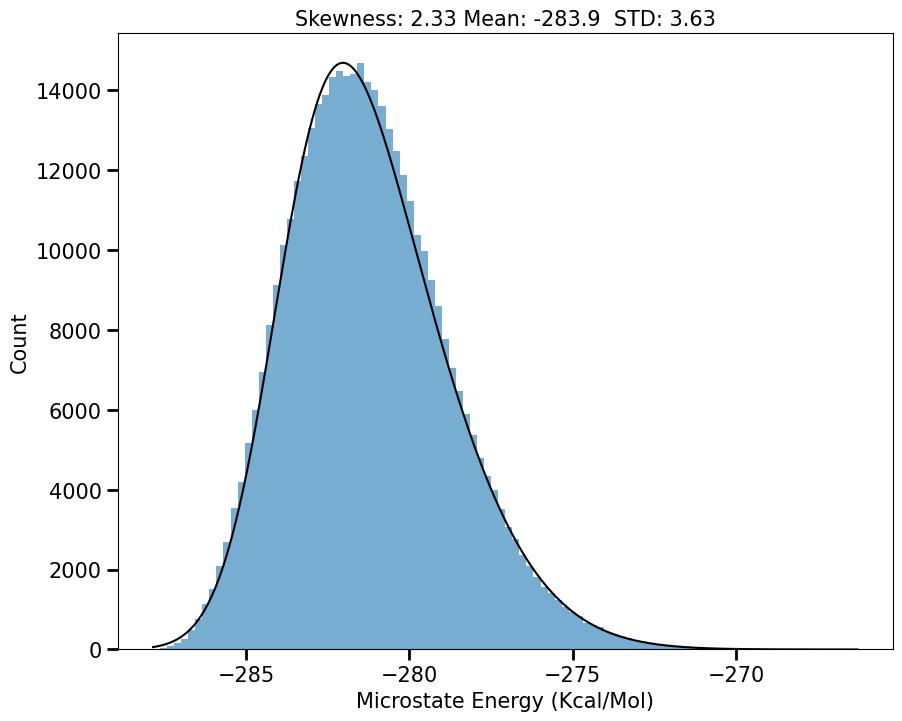

In [18]:
#plot the figure
fig = plt.figure(figsize=(10, 8))
graph_hist = plt.hist(
    energy_lst_count, bins=100, alpha=0.6
)
Y = graph_hist[0]
y = skewnorm.pdf(
    np.array(energy_lst_count), skewness, mean_, std_
)
#--scale back
pdf_data = Y.max() / max(y) * y
plt.plot(energy_lst_count, pdf_data, label='approximated shewnorm', color='black')
plt.title("Skewness: " + str(round(skewness, 2)) + " " \
          + "Mean: " + str(round(mean_, 2)) + " " + \
          " STD: " + str(round(std_, 2)), fontsize=15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("Microstate Energy (Kcal/Mol)", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.tick_params(
    axis="x", direction="out", length=8, width=2
)
plt.tick_params(
    axis="y", direction="out", length=8, width=2
)
fig.savefig("enthalpy_dis.pdf", dpi=600, bbox_inches = "tight")

### EDA (Exploratory Data Analysis)

In MCCE, there are groups for free and fixed residues.

Free residues appear in the microstate ID list, but fixed residues do not. Fixed residues can be titrating residues. Thus, it is important to look up these fixed residues and their contributions to the total charge, which is termd as background charges here.

First, we need to get access to conformer information from the corresponding MCCE run of the system used here.

In [19]:
head3_path = \
"/Users/delcck/Desktop/Research/Project_MCCE/work_dir/4lzt/head3.lst"

mc.conformers = msa.read_conformers(head3_path)

Then we examine the free residues information.

In [20]:
len(mc.conformers)

271

In [21]:
free_residues = []
for res in mc.free_residues:
    try:
        #free_residues.append(msa.conformers[res[0]].resid)
        free_residues.append(mc.conformers[res[0]].resid)
    except:
        print(res[0])
    

ms_free_residues = pd.DataFrame(free_residues, columns = ["Residue"])
ms_free_residues.head()

,Residue
0,GLUA0007_
1,HISA0015_
2,ASPA0018_
3,TYRA0020_
4,TYRA0023_


Fixed residues charge. Make sure look into fixed residues charge for MD protonation input.

In [22]:
# this is to write the fixed charge state
fixed_res_crg_dict = {}
for conf in mc.conformers:
    if conf.iconf in mc.fixed_iconfs:
        try:
            #initializing the dict
            if conf.resid not in fixed_res_crg_dict:
                fixed_res_crg_dict[conf.resid] = conf.crg
        except:
            print("Error in ms file! Fixed residues are duplicating")

background_charge = sum(fixed_res_crg_dict.values())
print(background_charge)

18.0


### Focused analyses on residues of interest

In [23]:
your_interested_res = \
 ["ASP", "MQ8", "GLU", "ARG", "HIS", "LYS", "SER", "CYS", "THR", "TYR", "NTR", "CTR"]

Keep only information related to our residues of interest.

In [24]:
fixed_interested_res = {
    i: j for i, j in fixed_res_crg_dict.items() if i[:3] in your_interested_res
}
fixed_residues_crg = pd.DataFrame(
    fixed_interested_res.items(), columns=["Residue", "crg"]
)
fixed_residues_crg.head()

,Residue,crg
0,NTRA0001_,1.0
1,LYSA0001_,1.0
2,ARGA0005_,1.0
3,LYSA0013_,1.0
4,ARGA0014_,1.0


In [25]:
print(len(fixed_interested_res))

21


Now, we will convert the microstate conformer if to its corresponding charge.

In [26]:
id_vs_charge = {}

for conf in mc.conformers:
    id_vs_charge[conf.iconf] = conf.crg

In [27]:
def convert_ms_crg(l, d):
    #A recursive function
    crg_lst = [
        [
            y[0], y[1], [convert_ms_crg(x, d) if isinstance(x, list) else d.get(x, x) for x in y[2]]
        ] for y in l
    ]
    return crg_lst

In [28]:
crg_orig_list = convert_ms_crg(ms_orig_list, id_vs_charge)

In [29]:
len(crg_orig_list)

411926

In [30]:
print(crg_orig_list[:2])

[[-287.853088, 21, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [-287.838135, 36, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]


### Obtain information about the unique charge state id, and corresponding count.

In [31]:
import sys

def find_unique_crgms_count_order(
    crg_list_ms, begin_energy = None, end_energy = None
):
    """
    Args:
        - crg_list_ms: the charge list of microstates. 
        * the crg file must have been sorted with increasing order.

        - begin_energy: min. enegy used for filtering charge id based on the ms' energy.
        - end_energy: min. enegy used for filtering charge id based on the ms' energy.
        * supplied together with begin_energy

    Return:
        - a unique_crg_state_order that gives the order of unique charge state based on energy. 
        * Lowest energy charge state will give the order 1 and then second unique charge 
        state will give the order 2. This order is based on unique charge ms order.
    """
    if not begin_energy and not end_energy:
        print("All energy microstates are selected.")
        begin_energy = crg_list_ms[0][0]
        eng_energy = crg_list_ms[-1][0]
    elif begin_energy and end_energy:
        crg_list_ms = [
            [x[0], x[1], x[2]]\
            for x in crg_list_ms \
            if x[0] >= begin_energy and x[0] <= end_energy
        ]
    else:
        #!! error here in the original code
        sys.exit('Give the lower and the upper energy bound.')

    #unique charge as key and energy, count and order
    crg_all_count = {}
    unique_crg_state_order = 1
    for x, array in enumerate(crg_list_ms):
        #adding new items
        if tuple(array[2]) not in crg_all_count.keys():
            crg_all_count[(tuple(array[2]))] = [
                array[1], [array[0]], [unique_crg_state_order]
            ]
            unique_crg_state_order += 1
        else:
            #in the case of a key has already been generated
            #update values, stored as a list, associated with that key
            crg_all_count[(tuple(array[2]))][0] += array[1]
            #update th min energy by:
            #1st, search for the min value in the updated list
            min_energy = min(min(
                crg_all_count[(tuple(array[2]))][1]
            ), array[0])
            max_energy = max(max(
                crg_all_count[(tuple(array[2]))][1]
            ), array[0])
            # clear the energy list and append min. and max. energy to it
            crg_all_count[(tuple(array[2]))][1].clear()
            crg_all_count[(tuple(array[2]))][1].append(min_energy)
            crg_all_count[(tuple(array[2]))][1].append(max_energy)

    # make a list of count, unique charge microstate, energy difference and order.
    all_crg_ms_unique = []
    all_count = []
    energy_diff_all = []
    unique_crg_state_order = []
    for u, v in crg_all_count.items():
        all_crg_ms_unique.append(list(u))
        all_count.append(v[0])
        unique_crg_state_order.append(v[2][0])
        if len(v[1]) == 2:
            energy_diff_all.append(round(v[1][1] - v[1][0], 6))
        elif len(v[1]) == 1:
            energy_diff_all.append(0)
        else:
            sys.exit("There is error while creating unique charge state.")

    print(f"Total number of state: {len(crg_list_ms)}")
    print(f"Total number of unique charge ms: {len(all_crg_ms_unique)}")
    return all_crg_ms_unique, all_count, unique_crg_state_order, energy_diff_all
            

In [32]:
def conca_crg_ms_pandas(
    unique_crg_ms_list, ms_count, ms_order, free_residues,
    background_charge, residue_interest_list
):
    unique_crg_ms_list_pd = pd.DataFrame(unique_crg_ms_list).T
    ms_count_pd = pd.DataFrame(ms_count, columns=["Count"]).T
    ms_order_pd = pd.DataFrame(ms_order, columns=["Order"]).T
    crg_ms_count_pd = pd.concat(
        [unique_crg_ms_list_pd, ms_count_pd, ms_order_pd]
    )
    crg_count_res_1 = pd.concat(
        [free_residues, crg_ms_count_pd], axis=1
    )
    crg_count_res_1.loc["Count", "Residue"] = 'Count'
    crg_count_res_1.loc["Order", "Residue"] = 'Order'
    all_crg_count_res = crg_count_res_1.set_index("Residue")
    # sort based on the count
    all_crg_count_res = all_crg_count_res.sort_values(
        by = "Count", axis = 1, ascending=False
    )
    all_crg_count_res.columns = range(all_crg_count_res.shape[1])
    all_crg_count_res = all_crg_count_res.T.set_index("Order")
    all_crg_count_res["Occupancy"] = round(
        all_crg_count_res["Count"] / sum(all_crg_count_res["Count"]), 3
    )
    all_crg_count_res['Sum_crg_protein'] = \
    all_crg_count_res.iloc[:, :-2].sum(axis=1) + background_charge
    crg_count_res = all_crg_count_res.copy()
    for i in all_crg_count_res.columns:
        if i[:3] not in residue_interest_list\
        and i != "Occupancy" \
        and i != "Count" \
        and i != "Sum_crg_protein":
            crg_count_res.drop([i], axis=1, inplace=True)

    return crg_count_res

### Select energy microstates associated with residues of interest

In [33]:
charge_ms_file = find_unique_crgms_count_order(crg_orig_list)

All energy microstates are selected.
Total number of state: 411926
Total number of unique charge ms: 46


In [34]:
all_crg_count_res = conca_crg_ms_pandas(
    charge_ms_file[0],
    charge_ms_file[1],
    charge_ms_file[2],
    ms_free_residues,
    background_charge,
    your_interested_res
)

In [35]:
all_crg_count_res.head()

Residue,GLUA0007_,HISA0015_,ASPA0018_,TYRA0020_,TYRA0023_,SERA0024_,GLUA0035_,SERA0036_,THRA0043_,THRA0047_,...,ASPA0087_,THRA0089_,SERA0100_,ASPA0101_,THRA0118_,ASPA0119_,CTRA0129_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1129301.0,0.753,19.0
2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190004.0,0.127,18.0
4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53465.0,0.036,18.0
3.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36175.0,0.024,18.0
5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,36096.0,0.024,18.0


In [51]:
type(all_crg_count)

pandas.core.frame.DataFrame

In [52]:
test_path = '/Users/delcck/Desktop/Research/Project_MCCE/work_dir/4lzt/test_case_for_namd.csv'

all_crg_count_res.to_csv(test_path, index=False)

### Visualize the tautomer charge distribution of unique charge microstate based on the occupancy.

Each dot is a unique charge microstate and its color code is based on the energy difference of that microstate appear in Monte Carlo run. The total charge is the sum of background charge and free charge (protein charge).

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [37]:
x_av = [
    sum(x) + background_charge for x in charge_ms_file[0]
]
y_av = [
    math.log10(x) for x in charge_ms_file[1]
]
energy_diff_all_fl = [
    float(x) for x in charge_ms_file[3]
]

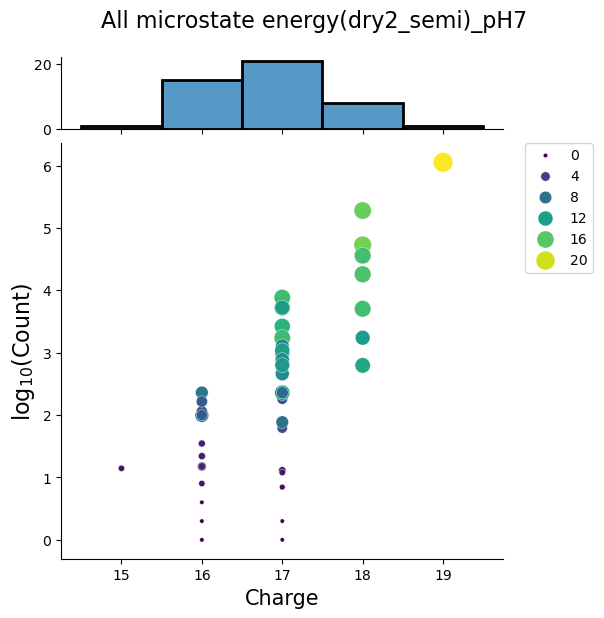

In [38]:
g1 = sns.JointGrid(marginal_ticks=True, height=6)
#--scatter plot
ax = sns.scatterplot(
    x=x_av, y=y_av, hue=energy_diff_all_fl,
    palette='viridis', size=energy_diff_all_fl,
    sizes=(10, 200), ax=g1.ax_joint
)
ax.set_xticks(range(int(min(x_av)), int(max(x_av)) + 1))
ax.set_xlabel("Charge", fontsize=15)
ax.set_ylabel("log$_{10}$(Count)", fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#--hist on top
ax2 = sns.histplot(x=x_av, linewidth=2, discrete=True, ax=g1.ax_marg_x)

ax2.set_ylabel(None, fontsize=16)
g1.ax_marg_y.set_axis_off()
g1.fig.subplots_adjust(top=0.9)
g1.fig.suptitle('All microstate energy(dry2_semi)_pH7', fontsize=16)
g1.savefig("all_en_cr_ph7_vs_log(count).pdf", dpi=600, bbox_inches="tight");

Now, let repeat the above process, but for microstate with an energy less than or equal to the lowest energy + 1.36KCal/Mol.

Make sure your supplied list is pre-sorted based on energy in ascednign order.

Below is a dataFrame for such an example.

In [39]:
lowest_charge_ms_file = find_unique_crgms_count_order(
    crg_orig_list, 
    begin_energy=crg_orig_list[0][0],
    end_energy=crg_orig_list[0][0] + 1.36
)
low_crg_count_res = conca_crg_ms_pandas(
    lowest_charge_ms_file[0],
    lowest_charge_ms_file[1],
    lowest_charge_ms_file[2],
    ms_free_residues,
    background_charge,
    your_interested_res
)

Total number of state: 1240
Total number of unique charge ms: 2


In [40]:
low_crg_count_res.head()

Residue,GLUA0007_,HISA0015_,ASPA0018_,TYRA0020_,TYRA0023_,SERA0024_,GLUA0035_,SERA0036_,THRA0043_,THRA0047_,...,ASPA0087_,THRA0089_,SERA0100_,ASPA0101_,THRA0118_,ASPA0119_,CTRA0129_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8957.0,0.999,19.0
2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.001,18.0


Now, we would try another example of getting microstates around +/- 0.5 pH unit (+/- 0.68 Kcal/Mol) of the average microstate energy.

Data shown in the resulting dataframe is here within the selected energy range.

In [42]:
average_charge_ms_file = find_unique_crgms_count_order(
    crg_orig_list,
    begin_energy=(mc.average_E - 0.68),
    end_energy=(mc.average_E + 0.68)
)
av_crg_count_res = conca_crg_ms_pandas(
    average_charge_ms_file[0],
    average_charge_ms_file[1],
    average_charge_ms_file[2],
    ms_free_residues,
    background_charge,
    your_interested_res
)

Total number of state: 90387
Total number of unique charge ms: 26


In [43]:
av_crg_count_res.head()

Residue,GLUA0007_,HISA0015_,ASPA0018_,TYRA0020_,TYRA0023_,SERA0024_,GLUA0035_,SERA0036_,THRA0043_,THRA0047_,...,ASPA0087_,THRA0089_,SERA0100_,ASPA0101_,THRA0118_,ASPA0119_,CTRA0129_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239661.0,0.733,19.0
4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47439.0,0.145,18.0
3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12467.0,0.038,18.0
6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,8737.0,0.027,18.0
9.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8479.0,0.026,18.0


Now, another example of getting the unique charge microstate of 1KT unit (1.36 Kcal/Mol) less of equal to the highest recorded energy state.

In [44]:
highest_charge_ms_file = find_unique_crgms_count_order(
    crg_orig_list,
    begin_energy=(mc.highest_E - 1.36),
    end_energy=(mc.highest_E)
)
high_crg_count_res = conca_crg_ms_pandas(
    highest_charge_ms_file[0],
    highest_charge_ms_file[1],
    highest_charge_ms_file[2],
    ms_free_residues,
    background_charge,
    your_interested_res
)

Total number of state: 4
Total number of unique charge ms: 1


In [45]:
high_crg_count_res.head()

Residue,GLUA0007_,HISA0015_,ASPA0018_,TYRA0020_,TYRA0023_,SERA0024_,GLUA0035_,SERA0036_,THRA0043_,THRA0047_,...,ASPA0087_,THRA0089_,SERA0100_,ASPA0101_,THRA0118_,ASPA0119_,CTRA0129_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,19.0


We now save all our calculated dataframe for later use.

In [46]:
# save all three data frames and non titrable residues charge informatino.
writer = pd.ExcelWriter('charge_ms_dry2_semi_pH7.xlsx', engine='xlsxwriter')
low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
fixed_residues_crg.to_excel(writer, sheet_name='fixed_residues_crg')
#writer.save() #removed in the most recent version of pandas & xlsxwrite
#use instead
writer.close()

In [47]:
all_crg_count_res.to_csv('all_crg_count_res.csv', header=True)

### Post processing of already saved files.

Our aim is to get the correlation matrix for residues

In [48]:
import pandas as pd

In [49]:
all_crg_count_read = pd.read_csv(
    'all_crg_count_res.csv', index_col=0
)
all_crg_count = all_crg_count_read.iloc[:, :-2]
all_crg_count = all_crg_count.T

In [50]:
all_crg_count.head()

Order,1.0,2.0,4.0,3.0,5.0,6.0,8.0,9.0,7.0,11.0,...,46.0,31.0,33.0,44.0,35.0,39.0,38.0,45.0,34.0,42.0
GLUA0007_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0
HISA0015_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ASPA0018_,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
TYRA0020_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TYRA0023_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
